In [1]:
#----------IMPORTS------------
import json, re
from pprint import pprint
from lxml import etree
import itertools
from pattern.nl import sentiment
import numpy as np
from nltk.tokenize import sent_tokenize
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


In [2]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

In [2]:
# this function replaces ugly links and images by simple, short and readable indicators. It also removes redundant markup from the file (bold, italics, etc).
def cleanup(text):
    text=re.sub('<a.*?>(.*?)</a>','\\1 (LINK)',text)
    text=re.sub('<img.*?title="(.*?)".*?/>', '(EMO:\\1)',text) # sommige emoticons worden ook geschreven als ':shock:', of gewoon als ':)'
    text=re.sub('<img.*?/>', '(IMG)',text)
    return(re.sub('</?(b|p|em|u|i|strong|br|span|div|blockquote|li)(.*?)/?>','',text)) # quotes worden vaak geforumuleerd als <bold>an schreef:</bold> TEXT. geen duidelijk einde van de quote. externe quotes zijn virtueel onherkenbaar.

In [3]:
def header(line):
    if 'Name' in line:
        print(line['Name'])
    if 'Title' in line:
        print(line['Title'])
    if 'Post date' in line:
        print(line['Post date'])
    if 'Datum van inzending' in line:
        print(line['Datum van inzending'])

In [126]:
# hier wordt AUTHORLIST gemaakt
def annotated_data(topics,posts):
    count=0
    questionmarks=0
    sentiment_list=0
    authorlist=[] # this will contain (author name, question marks, sentiment) for every bit of text ('topic' or 'post')

    #----------------------------------

    for x in topics:
        questionmarks=0
        sentiment_list=[]
        #header(x)
        clean_post=cleanup(x['Body'])
        #print(clean_post)

        for questionmark in re.findall('\?+',clean_post): 
            questionmarks+=1
        for sentence in sent_tokenize(clean_post):
            sentiment_list.append(sentiment(sentence)[0])
        authorlist.append((x['Author uid'],np.mean(sentiment_list),questionmarks))

        #print('Question marks:', questionmarks)
        #print('Sentiment:', sentiment_list) # the list is printed
        #print('\n')

        for y in reversed(posts): # need reversed to sort posts correctly
            if y['Forum Topic ID'] == x['Nid']:
                questionmarks=0
                sentiment_list=[]
                #header(y)
                clean_post=cleanup(y['Body'])
                #print(clean_post)

                for questionmark in re.findall('\?+',clean_post):
                        questionmarks+=1
                for sentence in sent_tokenize(clean_post):
                    sentiment_list.append(sentiment(sentence)[0])
                authorlist.append((y['Auteur-uid'],np.mean(sentiment_list),questionmarks))

                #print('Question marks:', questionmarks)
                #print('Sentiment:', sentiment_list)

                #print('\n')

        #print('\n------------- Einde topic -------------\n')

    #----------------------------------    
        count+=1 # makes output manageable
        if count>100:
            break
    return(authorlist)


In [3]:
sentiment('goed')

(0.55, 0.9)

In [87]:
# I do not know how to make the list of triples into a dictionary containing two lists as value in ONE step,
# so I make two dictionaries and combine those into one..

def make_dictionary(authorlist):
    author_sent = defaultdict(list)
    author_ques = defaultdict(list)
    for name, s_val, q_val in authorlist:
        author_sent[name].append(s_val) 
        author_ques[name].append(q_val)
    print('dictionaries generated')

    all_dict = defaultdict(list)
    for key in author_sent.keys():
        all_dict[key].append((author_sent[key]))
    for key in author_ques.keys():
        all_dict[key].append(author_ques[key])
    print('dictionaries combined')
    return(all_dict)

In [124]:
# Present the data. Here, I make a plot for every user, over time.
# also save to pdf
def plots_by_author(all_dict):
    pp = PdfPages("plots-author-BVN.pdf")
    for name in all_dict.keys():
        if len(all_dict[name][0]) > 15:
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()

            ax1.plot(all_dict[name][0], 'g-', alpha=0.5) # green = sentiment
            ax2.plot(all_dict[name][1], 'r-', alpha=0.5) # red = question marks
            ax1.set_ylabel('Sentiment', color='g')
            ax2.set_ylabel('Question Marks', color='r')

            ax1.set_ylim(-1,1)
            ax2.set_ylim(-5,5)
            plt.title(name)

            figur=plt.figure(1)
            plt.show()
            pp.savefig(figur, dpi = 300, transparent = True)
    pp.close()

In [143]:
# Present the data differently: Here I make a plot for every variable.
# I doubt whether it provides a lot of insight, as I expect that every patient needs different amounts of time to get empowered by the forum
# therefore, empowered and disempowered patients probably level each other out.
# In any case I got to experiment with line plots and scatter plots and trend lines.

def scatter_plots_by_variable(all_dict):
    pp = PdfPages("plots-variable-BVN.pdf")
    j=0
    for j in range(len(all_dict.values()[0])):

        plotlist=[]
        lenlist=[]
        listlist=[]
        
        i=0
        while i>=0:
            somelist=[]

            for name in all_dict:
                if len(all_dict[name][j])>i:
                    somelist.append(all_dict[name][j][i])
                    #print(somelist)
                else:
                    #print(len(all_dict[name][j]),'<',i)
                    pass
            if len(somelist) == 0:
                break
            else:
                listlist.append(somelist)
                plotlist.append(np.mean(somelist))
                lenlist.append(len(somelist))
                i+=1

    # plots showing means per post and trend lines  
        plt.close()        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        x = np.array([i for i in range(len(plotlist))])
        y = plotlist

        ax1.scatter(x,y,s=5, color='green',alpha=0.6) # green = sentiment
        ax2.plot(lenlist, 'r-', alpha=0.2) # red = question marks

        #fit = np.polyfit(x-np.mean(x), y,1)
        #ax1.plot(x, fit[0] * x + fit[1], 'b-', alpha=0.8)

        ax1.set_ylabel('Mean', color='g')
        ax2.set_ylabel('Frequency', color='r')
        ax1.set_xlim(0,)

        if j==0:
            ax1.set_ylim(0,1)
            ax2.set_ylim(0,15)
            plt.title('Mean sentiment per post')
        else:
            ax1.set_ylim(0,6)
            ax2.set_ylim(0,15)
            plt.title('Mean nr of question marks per post')
        j+=1
        
    # scatter plot of all measured values
        #n=0
        #for lists in listlist:
        #    for elements in lists:
        #        ax1.scatter(n,elements, color='blue', s=3, alpha=0.4) # adjusting s to s=len(lists) changes the size of the dots respective to the nr of measurements. would be cool to do with means
        #    n+=1
        figur=plt.figure(1)
        plt.show()
        pp.savefig(figur, dpi = 300, transparent = True)
    pp.close()

plots closed
dictionaries generated
dictionaries combined


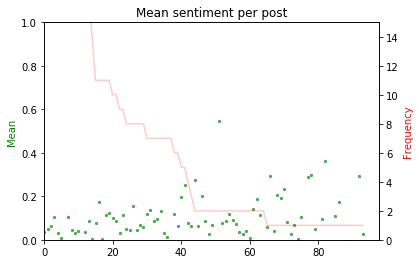

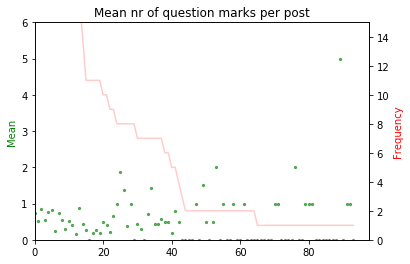

In [144]:
plt.close()
print('plots closed')

authorlist=annotated_data(topics, posts)
#pprint(authorlist)
all_dict=make_dictionary(authorlist)
#pprint(all_dict.items())
#plots_by_author(all_dict)
scatter_plots_by_variable(all_dict)